# IMDB 리뷰 감성 분류 - CNN

## 라이브러리 임포트

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 학습 데이터 경로 정의

In [ ]:
DATA_PATH = '/content/drive/MyDrive/nlpdata/imdb/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

## 데이터 로드

In [ ]:
train_input = np.load(open(DATA_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = prepro_configs = json.load(open(DATA_PATH + DATA_CONFIGS, 'r'))

## 모델 하이퍼파라메터 정의

In [ ]:
model_name = 'cnn_classifier'
BATCH_SIZE = 512
NUM_EPOCHS = 2
VALID_SPLIT = 0.2
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}

## 모델 정의

In [ ]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                                   for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

## 모델 컴파일

In [ ]:
model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

## Callback 선언

In [ ]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
checkpoint_path = DATA_PATH + '/weights_cnn.h5'
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

## 모델 학습

In [ ]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/2
40/40 [==============================] - 40s 171ms/step - loss: 0.6921 - accuracy: 0.5323 - val_loss: 0.6262 - val_accuracy: 0.7520

Epoch 00001: val_accuracy improved from -inf to 0.75200, saving model to /content/drive/MyDrive/nlpdata/imdb/weights_cnn.h5
Epoch 2/2
40/40 [==============================] - 6s 161ms/step - loss: 0.5233 - accuracy: 0.7792 - val_loss: 0.3265 - val_accuracy: 0.8616

Epoch 00002: val_accuracy improved from 0.75200 to 0.86160, saving model to /content/drive/MyDrive/nlpdata/imdb/weights_cnn.h5


## 결과 플롯

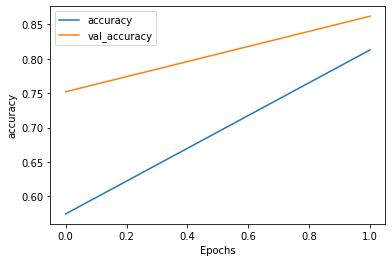

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## 테스트 데이터 불러오기

In [ ]:
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

## 베스트 모델 불러오기

In [ ]:
model.load_weights(os.path.join(DATA_PATH, 'weights_cnn.h5'))

## 테스트 데이터 예측하기

In [ ]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [ ]:
test_id = np.load(open(DATA_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)
output = pd.DataFrame(data={"id": list(test_id), "sentiment": list(predictions)} )
output.to_csv(DATA_PATH + 'answer_cnn.csv', index=False, quoting=3)

## kgggle에 결과 제출 및 스코어 확인
- https://www.kaggle.com/c/word2vec-nlp-tutorial